In [2]:
from pathlib import Path

from fastai.vision.all import load_learner
import numpy as np
from PIL import Image


In [3]:
def add_mask2(source: Image.Image, truth: np.ndarray, pred: np.ndarray) -> Image.Image:
    """
    Given source black and white image, true and predicted mask this function returns image
    with areas colored as following:
    - Green - annotation only
    - Red - prediction only
    - Yellow - overlap
    """
    source = source.convert('RGBA')
    M = np.zeros((*truth.shape, 4), dtype=np.uint8)
    M[:, :, 1] = truth[:, :] * 255
    M[:, :, 0] = pred[:, :] * 255
    M[:, :, 3] = ((truth > 0) | (pred > 0)) * 75
    
    mask = Image.fromarray(M, 'RGBA')
    return Image.alpha_composite(source, mask)

In [4]:
def image2segmentation_path(imgpath: Path) -> Path:
    return Path(str(imgpath).replace("inputs", "segmentations"))

def pixels2area(n: int) -> float:
    """Converts number of pixels into area in um^2"""
    return n * 0.023 * 0.023

def area2mass(A: float) -> float:
    """Converts area in um^2 into mass in mg"""
    return 0.197 * (A ** 1.38)

In [5]:
model = load_learner("models/learner.pkl")  # File models/learner.pkl
model.load("model_resnet34")  # File models/model_resnet34.pth
model.dls.device = 'cpu' 

/opt/conda/envs/copepods/lib/python3.9/site-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


In [6]:
imgs = sorted(list(Path("example_inputs").glob("*.bmp")))
imgs

[Path('example_inputs/20130815 104202 761 000000 0103 0536.bmp'),
 Path('example_inputs/20130815 104207 359 000000 0147 0692.bmp'),
 Path('example_inputs/20130815 104356 582 000000 0975 0248.bmp'),
 Path('example_inputs/20130815 104410 776 000000 0155 0860.bmp'),
 Path('example_inputs/20130815 104421 866 000000 0348 0212.bmp'),
 Path('example_inputs/20130815 143649 276 000000 0025 0140.bmp'),
 Path('example_inputs/20130818 111702 389 000003 0992 0078.bmp'),
 Path('example_inputs/20130818 112146 245 000000 0496 0332.bmp'),
 Path('example_inputs/20130818 112200 905 000002 0025 0185.bmp'),
 Path('example_inputs/20130902 163759 688 000000 0946 0066.bmp'),
 Path('example_inputs/20130902 221000 109 000001 0299 0118.bmp')]

In [7]:
# Change number 0 to number 0-10 or provide your own paths for image and segmentation.
# If there is no segmentation make p_segmentation = None
pimg = imgs[1]
p_segmentation = image2segmentation_path(pimg)
# p_segmentation = None
pimg

Path('example_inputs/20130815 104207 359 000000 0147 0692.bmp')

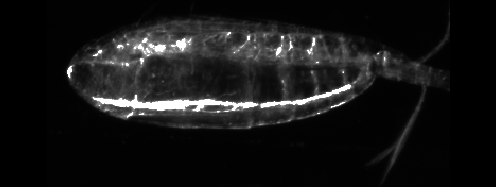

In [8]:
im = Image.open(pimg)
im

Lipid annotation: 3.0408mg
Lipid prediction: 2.7005mg


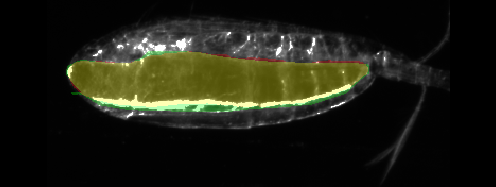

In [9]:
im = Image.open(pimg)
mask, *_ = model.predict(pimg)
im_pred_mask = mask.numpy()

if p_segmentation is not None:
    im_truth = np.array(Image.open(p_segmentation).convert("L"))
else:
    im_truth = np.zeros_like(im_pred_mask)

img_with_masks = add_mask2(im, im_truth, im_pred_mask)

lipid_annotated = area2mass(pixels2area((im_truth > 0).sum()))
lipid_predicted = area2mass(pixels2area((im_pred_mask > 0.5).sum()))
print(f"Lipid annotation: {lipid_annotated:.5}mg")
print(f"Lipid prediction: {lipid_predicted:.5}mg")
# Green - annotation
# Red - prediction
# Yellow - overlap
img_with_masks.convert("RGB")